In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from datetime import datetime
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/wide/hres/N_1/


In [2]:
#Load simulation data
var1, var2, times = load_data('omegaY_xy', 'w_xy')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Plume penetration occured at t=2.3545


In [3]:
# Time control
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per

In [4]:
print(md)

{'LX': 1.0, 'LY': 1.0, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 1.575, 'NU_START': 1e-07, 'SAVE_FLOW_DT': 50.0, 'VERSION': 3.12, 'NU_START_TIME': 50.0, 'SAVE_STATS_DT_FINE': 0.126, 'FINE_RES_TIME': 1.0, 'TIME_LIMIT': 25.2, 'NBUOY_PERIODS': 3.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 1024, 'Ny': 1024, 'Nz': 513, 'Nth': 2}


In [5]:
#Create grid
X, Y = np.meshgrid(gx, gy)
Xf, Yf = np.meshgrid(gxf, gyf)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 156
Dimensional times:  [-2.35450823 -0.77950823  0.          1.575       3.15        4.725
  6.3         6.426       6.552       6.678       6.804       6.93
  7.056       7.182       7.308       7.434       7.56        7.686
  7.812       7.938       8.064       8.19        8.316       8.442
  8.568       8.694       8.82        8.946       9.072       9.198
  9.324       9.45        9.576       9.702       9.828       9.954
 10.08       10.206      10.332      10.458      10.584      10.71
 10.836      10.962      11.088      11.214      11.34       11.466
 11.592      11.718      11.844      11.97       12.096      12.222
 12.348      12.474      12.6        12.726      12.852      12.978
 13.104      13.23       13.356      13.482      13.608      13.734
 13.86       13.986      14.112      14.238      14.364      14.49
 14.616      14.742      14.868      14.994      15.12       15.246
 15.372      15.498      15.624      15.75       15.876      16.002
 16.128  

Setting up initial plot...
Starting plot...


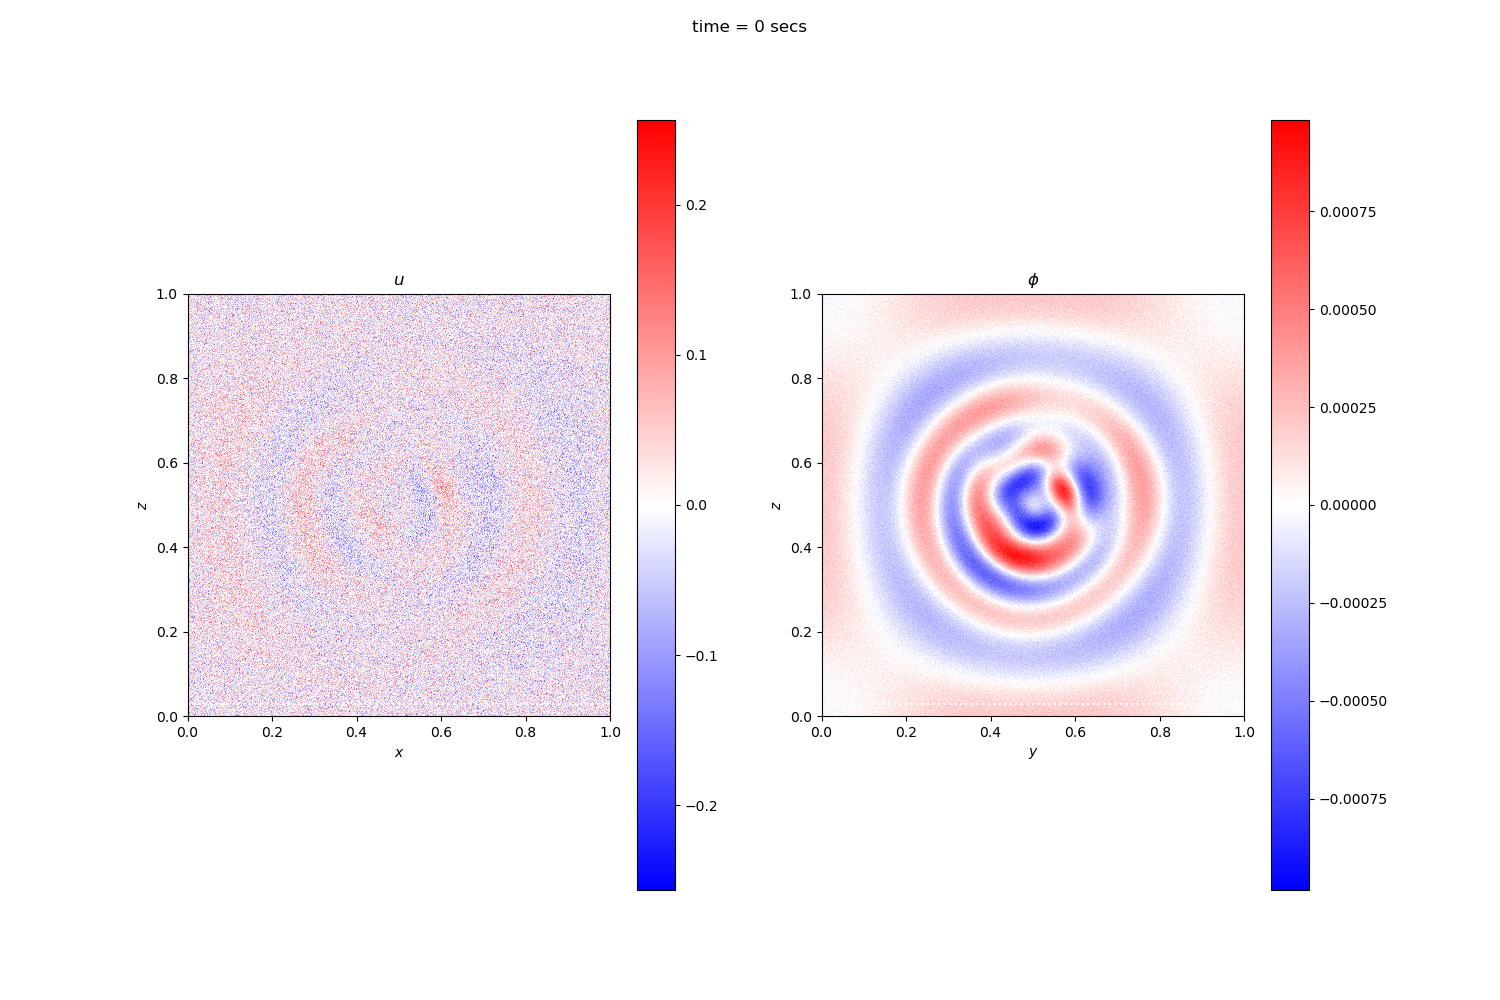

In [6]:
# print("Setting up data arrays...")
fig, axs = plt.subplots(1,2,figsize=(15, 10))
ims = np.array([None,None])
cb = np.array([None,None])

print("Setting up initial plot...")
ims[0] = axs[0].pcolormesh(X, Y, var1[-1], cmap='bwr', norm=colors.CenteredNorm())
ims[1] = axs[1].pcolormesh(X, Y, var2[-1], cmap='bwr', norm=colors.CenteredNorm())

# Add forcing level
axs[0].axhline(md['Lyc']+md['Lyp'],color='white', linestyle=':')
axs[1].axhline(md['Lyc']+md['Lyp'],color='white', linestyle=':')

cb[0] = plt.colorbar(ims[0],ax=axs[0])
cb[1] = plt.colorbar(ims[1],ax=axs[1])


fig.suptitle("time = 0 secs")
axs[0].set_ylabel("$z$")
axs[1].set_ylabel("$z$")
axs[0].set_xlabel("$x$")
axs[1].set_xlabel("$y$")

#axs[0].set_ylim(md['H'], 2*md['H'])
#axs[1].set_ylim(md['H'], 2*md['H'])

#axs[0].set_xlim(0.4, 0.6)
#axs[1].set_xlim(0.4, 0.6)

axs[0].set_aspect(1)
axs[1].set_aspect(1)

axs[0].set_title(r"$u$")
axs[1].set_title(r"$\phi$")

def animate(step):
    ims[0].set_array(var1[step].ravel())
    ims[1].set_array(var2[step].ravel())
    fig.suptitle("time = {0:.2f} secs".format(times[step]))

    return ims.flatten(),

#print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(fig, animate, interval=1000*md['SAVE_STATS_DT_FINE'], frames=NSAMP, repeat=True)
now = datetime.now()
#anim.save(save_dir+'shear_%s.mp4'%now.strftime("%d-%m-%Y"),writer=writer)

plt.show()
#save_fig(anim, '/home/cwp29/tmp/nlwf.mp4', anim=True, dpi=300)